# 1 - Multi-armed bandits (3 pts.)
In this part of the homework, you will reproduce some of the results in Chapter 2 of the Sutton and Barto
book.

Suppose that you have a 10-armed bandit problem—i.e., an agent has to select among a set of 10
different actions, each of which yields a different (average) reward. In particular, suppose that the actual
reward associated with each action a ∈ {1, . . . , 10} is a random variable following a Gaussian distribution
with mean Q(a) and variance 1.  
You will compare the average reward received by:  
>• A greedy policy, where the estimated reward for each action a is initialized as Qˆ(a) = 0;  
    • A greedy policy, where the estimated reward for each action a is initialized as Qˆ(a) = 5;  
    • An ε-greedy policy, with ε = 0.1, where the estimated reward for each action a is initialized as Qˆ(a) = 0;  
    • An ε-greedy policy, with ε = 0.01, where the estimated reward for each action a is initialized as Qˆ(a) = 0;  
    • The UCB policy. 

To do this

1. Select the average values Q(a), a ∈ {1, . . . , 10} , at random from a normal distribution with mean 0 and variance 1;
2. Run the policies listed above for 1, 000 steps and compute, for each policy, the reward received at each time step;
3. Repeat the two previous steps 2, 000 times;
4. Compute the reward obtained at each time step by each of the policies averaged across the 2, 000 trials.

**Question 1. Using the results from the procedure outlined above, plot the average reward obtained with each policy during the 1, 000 steps in a single plot. Comment the differences observed.**

### Notes

A greedy policy is an ε-greedy policy with ε = 0;  
NumPy provides a normal distribution: https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html;

Logic is given by:


![image.info](./pictures/bandit.png)


Previous image is from the *Reinforcement Learning: An Introduction* book, by Sutton and Barto, found in:  
http://incompleteideas.net/sutton/book/the-book-2nd.html

In [704]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns

import copy
# from numpy.random import default_rng

## Generic Bandit class

In [732]:
# Attempt a simple bandit

class Bandit(object):
    
    # Variable initialization
    def __init__(self, n_actions=10, iterations=1000, use_ucb=True, initial_estimate=0.0, epsilon=0.0, c=0.0):
        # Set the size of action space
        self.n_actions = n_actions
        
        # Initial Q(a) value array
        self.q_actions = np.random.normal(loc=0.0, scale=np.sqrt(1), size=n_actions)
        
        # Value of picking an action
        self.rewards = None
        
        # Initial reward for mean calculation
        self.reward_mean = None
        
        # Initial estimate for Q^(a)
        self.estimates = np.array([initial_estimate for i in np.arange(self.n_actions)])
        
        # Times chosen each action
        self.times_chosen = np.zeros(self.n_actions)
        
        # Number of iteration
        self.max_iterations = iterations
        
        # Number of timesteps
        self.timestep = 0
        
        # Whether we used or not the UCB
        self.is_UCB = use_ucb
        
        # Epsilon for greedy - greedy is 0
        self.epsilon = epsilon
        
        # Constant C value for UCB
        self.c_value = c
        
        # Total reward
        self.total_reward = 0.0
        
        # Records
        self.records = None
    
    # Get Q(a) at timestep n+1
    def __update_action_value__(self, action_index, reward):
        self.estimates[action_index] += (reward - self.estimates[action_index]) / self.times_chosen[action_index]
        #next_qa = (current_q) + ((current_r - current_q) * (times_chosen ** -1))
        #next_qa = (1 - 1.0/times_chosen) * current_q + (1.0/times_chosen) * current_r
        return
        
    # Pick action A at t+1
    def __select_action_ucb__(self):
        next_action = np.argmax([self.estimates[i] + self.c_value * np.sqrt(np.log(self.timestep) / (self.times_chosen[i])) 
                                 for i in np.arange(self.n_actions)])
        return next_action
    
    
    def __select_action_epsilon__(self):
        if np.random.random() <= self.epsilon:
            known_action = np.argmax(self.estimates)
            
            # Generate probs for each action
            prob_actions = np.random.standard_normal(size=self.n_actions)
            prob_actions[known_action] = -999
            return np.argmax(prob_actions)
        else:
            return np.argmax(self.estimates)
        
        
    def __complete_records__(self, total_reward, action_picked, reward_received):
        new_df = pd.DataFrame({'Cumulative Reward': total_reward,
                               'Picked Action': action_picked,
                               'Reward Received': reward_received}, 
                              index=np.arange(1, len(total_reward)+1))
        new_df['Average Reward'] = new_df['Cumulative Reward'].values / np.arange(1, len(total_reward)+1)
        
        return new_df
            
            
    def iterate(self):
        # 1 - Initialize Q(a) -> done on class initialization
        # 2 - Initialize rewards from normal distribution with mean = Q(a)
        # 3 - If is UBC, pick each action exactly once first
        # 4 - Pick action based on the UCB or greedy
        # 5 - Get reward for action selected
        # 6 - Update counter of selection for action selected
        # 7 - Get new Q(a) for the selected action
        
        self.reward_mean = copy.deepcopy(self.q_actions)
        #print(self.q_actions)
        
        records_total_reward = np.array([])
        records_action_picked = np.array([])
        records_reward_received = np.array([])
        
        if self.is_UCB:
            # Pick each action once
            for action in np.arange(self.n_actions):
                
                # Get rewards at current time step
                temp_rewards = np.zeros(self.n_actions)
                for arm_reward in np.arange(self.n_actions):
                    temp_rewards[arm_reward] = np.random.normal() + self.reward_mean[arm_reward]
                self.rewards = temp_rewards
                
                # Update counters
                self.times_chosen[action] += 1
                self.timestep += 1
                 
                #updated_qa = self.__update_action_value__(current_q=self.estimates[action],
                #                                          current_r=self.rewards[action],
                #                                          times_chosen=self.times_chosen[action])
                
                self.__update_action_value__(action_index=action, reward=self.rewards[action])
                # self.estimates[action] = updated_qa
                # generate new reward
                
                
                self.total_reward += self.rewards[action]

                records_total_reward = np.append(records_total_reward, self.total_reward)
                records_action_picked = np.append(records_action_picked, action)
                records_reward_received = np.append(records_reward_received, self.rewards[action])
        
        for iteration in np.arange(self.max_iterations):
            
            # Generate new rewards based on a distribution with mean = initial_qa, variance = 1
            # self.rewards = self.__generate_normal__(mean=self.initial_qa)
            
            # Pick action
            picked_action = 0
            if self.is_UCB:
                picked_action = self.__select_action_ucb__()
            else:
                picked_action = self.__select_action_epsilon__()
            
            # Update timestep and action counter
            self.times_chosen[picked_action] += 1
            self.timestep += 1
            
            # Generate rewards at current time step from a normal distribution with mean=Q(a)
            temp_rewards = np.zeros(self.n_actions)
            for arm_reward in np.arange(self.n_actions):
                temp_rewards[arm_reward] = np.random.normal() + self.reward_mean[arm_reward]
                
            self.rewards = temp_rewards
            

            # Update Q(a)
            #updated_qa = self.__update_action_value__(current_q=self.estimates[picked_action], 
            #                                          current_r=self.rewards[picked_action],
            #                                          times_chosen=self.times_chosen[picked_action])
            #self.estimates[picked_action] = updated_qa
            
            self.__update_action_value__(action_index=picked_action, reward=self.rewards[picked_action])
            self.total_reward += self.rewards[picked_action]
            
            records_total_reward = np.append(records_total_reward, self.total_reward)
            records_action_picked = np.append(records_action_picked, picked_action)
            records_reward_received = np.append(records_reward_received, self.rewards[picked_action])
        
        self.records = self.__complete_records__(records_total_reward, records_action_picked,
                                                 records_reward_received)
        
        return self.records
    
    
    def plot_rewards(self, title=None):
        if self.records is not None:
            
            fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(20, 8))

            axs[0].plot(self.records['Cumulative Reward'])
            axs[0].set_xlabel('Iterations')
            axs[0].set_ylabel('Cumulative Reward')
            axs[0].set_title('Cumulative Reward over Iterations')

            axs[1].plot(self.records['Average Reward'])
            axs[1].set_xlabel('Iterations')
            axs[1].set_ylabel('Average Reward')
            axs[1].set_title('Average Reward over Iterations')
            
            axs[2].plot(self.records['Reward Received'])
            axs[2].set_xlabel('Iterations')
            axs[2].set_ylabel('Reward Received')
            axs[2].set_title('Reward Received over Iterations')
            
            fig.suptitle(title, fontsize=14)

            plt.show()

## Test example

In [739]:
# Instantiate the Bandit class for UCB with C=0.2 (for test)

bandit = Bandit(iterations=2000, use_ucb=True, epsilon=0.5, c=1.0, initial_estimate=0)
bandit.iterate()

,Cumulative Reward,Picked Action,Reward Received,Average Reward
1,-1.981544,0.0,-1.981544,-1.981544
2,-3.725197,1.0,-1.743652,-1.862598
3,-3.648310,2.0,0.076887,-1.216103
4,-4.829227,3.0,-1.180917,-1.207307
5,-4.701266,4.0,0.127961,-0.940253
...,...,...,...,...
2006,-930.048187,5.0,-1.183716,-0.463633
2007,-929.754212,6.0,0.293975,-0.463256
2008,-931.755090,7.0,-2.000878,-0.464021
2009,-933.333813,8.0,-1.578723,-0.464576


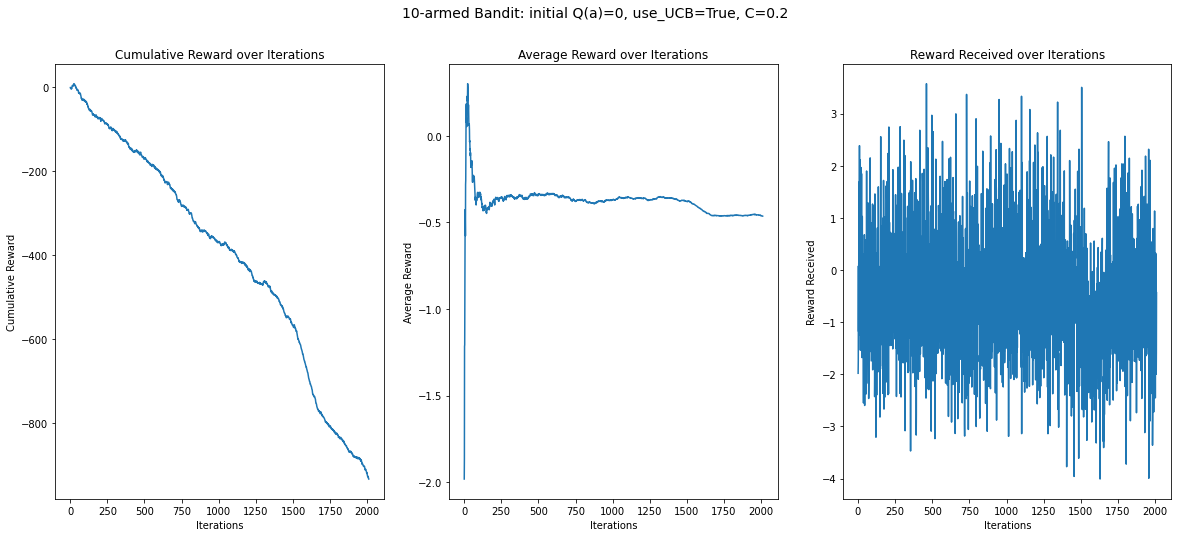

In [740]:
# Plot the Cumulative Reward and Average Reward (for test)

bandit.plot_rewards('10-armed Bandit: initial Q(a)=0, use_UCB=True, C=0.2')

## MultiBandit class

In [744]:
# Define a class for running multiple instances of a 10-armed bandit problem

class MultiBandit(object):
    
    def __init__(self, experiment_iter=2000, bandit_iter=1000, number_actions=10,
                 use_UCB=False, c=0, epsilon=0, initial_estimate=0, column=None):
        
        # Number of bandits to run
        self.experiment_iter = experiment_iter
        
        # Iterations of each bandit
        self.bandit_iter = bandit_iter
        
        # Action space size for each bandit
        self.number_actions = number_actions
        
        # If use UCB
        self.use_UCB = use_UCB
        
        # C value for the UCB
        self.c = c
        
        # Epsilon for epsilon-greedy
        self.epsilon = epsilon
        
        # Initial Q^(a) values
        self.initial_estimate = initial_estimate
        
        # Bandit dictionary collection
        self.bandit_records = {}
        
        # Column to analyze
        self.column = column
        
        # Averaged results
        self.results = None

    def __multi_bandit__(self, experiment_iter, bandit_iter, number_actions=10, use_UCB=False, 
                         c=0, epsilon=0, initial_estimate=0):

        for i in tqdm.notebook.trange(self.experiment_iter):
            temp_bandit = Bandit(n_actions=self.number_actions, iterations=self.bandit_iter, 
                                 epsilon=self.epsilon, use_ucb=self.use_UCB, c=self.c, 
                                 initial_estimate=self.initial_estimate)
            temp_bandit.iterate()

            self.bandit_records['Run {:0004d}'.format(i+1)] = temp_bandit

        return


    # Get the averaged results for a column
    def __average_results__(self, dictionary, column):
        if self.column is not None:
            current_results = {}
            for run in tqdm.notebook.trange(len(dictionary)):
                current_results[list(dictionary.keys())[run]] = dictionary[list(dictionary.keys())[run]].records[column]

            return pd.DataFrame(current_results)
        else:
            return
        
        
    def iterate(self):
        self.__multi_bandit__(experiment_iter=self.experiment_iter, bandit_iter=self.bandit_iter, 
                              number_actions=self.number_actions, use_UCB=self.use_UCB, epsilon=self.epsilon, 
                              initial_estimate=self.initial_estimate)
        self.results = self.__average_results__(self.bandit_records, self.column)
        
        return self.results
        

In [745]:
# A greedy policy, where the estimated reward for each action a is initialized as Qˆ(a) = 0;

greedy_bandit_q0 = MultiBandit(use_UCB=False, epsilon=0, initial_estimate=0, column='Average Reward')
greedy_bandit_q0.iterate()

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

,Run 0001,Run 0002,Run 0003,Run 0004,Run 0005,Run 0006,Run 0007,Run 0008,Run 0009,Run 0010,...,Run 1991,Run 1992,Run 1993,Run 1994,Run 1995,Run 1996,Run 1997,Run 1998,Run 1999,Run 2000
1,-0.099367,-1.594880,0.039649,-0.111789,-1.529554,1.842657,0.180146,-1.124495,1.479084,-0.134149,...,-1.686910,1.945611,-2.167124,2.566640,0.601801,-1.451532,1.059916,3.749109,1.528500,0.228356
2,0.000759,-0.709956,0.385406,-0.433710,-0.516137,1.917854,0.932699,0.038925,1.158114,0.185293,...,-1.406492,0.558402,-0.855669,1.951458,-0.009235,-1.733237,1.795795,3.829818,1.321126,0.156121
3,0.182869,-0.432406,0.090366,-0.204006,0.114395,1.410711,1.000676,1.095548,1.055923,-0.103577,...,-1.087068,0.423266,-0.601801,1.362279,-1.113916,-0.757190,1.782779,3.732078,0.967077,0.106811
4,-0.019503,-0.457168,0.184834,0.067881,-0.006757,1.272450,1.007280,1.719816,1.083687,0.255156,...,-0.917360,0.015100,-0.164581,1.392299,-0.752807,-0.287705,1.553838,3.575308,0.724284,0.253246
5,-0.157765,-0.228753,-0.228014,0.192117,0.128776,1.046929,0.780385,1.718734,1.004039,0.240662,...,-0.686727,-0.352152,-0.060499,1.339978,-0.892899,-0.211733,1.817202,3.442653,0.485370,-0.243795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,0.240270,0.405818,-0.172527,-0.751310,-0.013293,0.467583,0.544089,1.358782,0.975580,0.475645,...,0.362060,-1.034488,0.057198,1.101081,0.982772,0.570660,1.254028,3.682404,0.043575,0.231881
997,0.240336,0.406234,-0.173168,-0.750254,-0.013913,0.468879,0.544936,1.357974,0.976925,0.476576,...,0.362886,-1.033790,0.056419,1.099876,0.983289,0.571548,1.254805,3.681485,0.045778,0.231575
998,0.239125,0.405790,-0.174098,-0.752807,-0.014209,0.470223,0.545539,1.357335,0.976023,0.474246,...,0.362045,-1.033147,0.056305,1.097698,0.981934,0.571967,1.256097,3.681576,0.046266,0.231311
999,0.238939,0.405929,-0.173941,-0.752234,-0.015722,0.470186,0.544395,1.355929,0.975266,0.475773,...,0.361643,-1.032163,0.055101,1.096484,0.982142,0.572242,1.256468,3.683150,0.047234,0.231492


In [746]:
# A greedy policy, where the estimated reward for each action a is initialized as Qˆ(a) = 5;

greedy_bandit_q5 = MultiBandit(use_UCB=False, epsilon=0, initial_estimate=5, column='Average Reward')
greedy_bandit_q5.iterate()

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

,Run 0001,Run 0002,Run 0003,Run 0004,Run 0005,Run 0006,Run 0007,Run 0008,Run 0009,Run 0010,...,Run 1991,Run 1992,Run 1993,Run 1994,Run 1995,Run 1996,Run 1997,Run 1998,Run 1999,Run 2000
1,-2.087762,-2.921614,2.943719,0.327141,0.182934,-0.677299,0.972793,2.730726,-0.805869,-1.601559,...,-1.362873,0.471470,2.625644,-1.013589,-0.628286,0.352672,-1.191911,3.025429,0.886541,-0.178354
2,-2.226986,-0.230715,2.279400,0.748771,-0.599799,-1.441636,-0.180531,1.874098,-0.576456,-0.567047,...,-0.635251,0.407695,1.380779,-0.473871,-0.713302,0.920688,0.630548,1.771072,0.935921,-0.480740
3,-1.642727,0.294281,1.732150,1.200155,-0.961743,-1.154442,-0.692815,1.643992,-0.042181,-0.728837,...,-0.602492,0.320920,1.913655,-0.244721,-0.822934,0.416619,0.381506,1.459131,-0.332189,0.203465
4,-1.369688,-0.489196,0.784878,1.333109,-0.516981,-1.136456,-0.019112,1.611032,-0.731603,-0.834838,...,-0.301375,0.234720,1.713020,-0.528994,-0.258557,0.332461,0.411401,1.375063,0.268320,0.066072
5,-1.597847,-0.421484,0.963500,0.939781,0.009868,-0.562251,0.232009,1.317173,0.014359,-0.735876,...,-0.087765,-0.043526,1.736933,-0.702945,-0.206964,0.452647,0.357437,1.027790,0.241099,0.062137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,0.566976,2.212764,-0.047465,0.592762,0.150225,-0.900593,1.081150,1.067739,-0.124206,0.716434,...,0.172518,0.662623,1.175560,0.267769,0.180513,-0.054999,1.040113,0.535057,-0.098651,0.265796
997,0.566550,2.213291,-0.047275,0.592074,0.150857,-0.900341,1.081728,1.069172,-0.124350,0.716574,...,0.171191,0.663868,1.176475,0.267571,0.181686,-0.056431,1.039098,0.534767,-0.099053,0.266205
998,0.566375,2.214468,-0.047703,0.592515,0.152532,-0.900031,1.081482,1.069671,-0.125225,0.716374,...,0.173556,0.663679,1.175003,0.267322,0.180247,-0.056069,1.037554,0.535340,-0.098797,0.266700
999,0.567216,2.213076,-0.048481,0.592235,0.154335,-0.900481,1.080807,1.071714,-0.125155,0.714770,...,0.174235,0.663743,1.174438,0.268566,0.179930,-0.056893,1.037116,0.537005,-0.099211,0.266511


In [747]:
# An ε-greedy policy, with ε = 0.1, where the estimated reward for each action a is initialized as Qˆ(a) = 0;  

egreedy_bandit_e01 = MultiBandit(use_UCB=False, epsilon=0.1, initial_estimate=0, column='Average Reward')
egreedy_bandit_e01.iterate()

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

,Run 0001,Run 0002,Run 0003,Run 0004,Run 0005,Run 0006,Run 0007,Run 0008,Run 0009,Run 0010,...,Run 1991,Run 1992,Run 1993,Run 1994,Run 1995,Run 1996,Run 1997,Run 1998,Run 1999,Run 2000
1,-1.047752,-1.407673,-1.325995,-0.975267,-1.862958,-2.743737,2.302572,0.102171,0.211033,2.443636,...,-0.810638,1.071920,2.711536,1.313967,-0.626740,0.609138,1.080922,1.827571,1.293998,-1.429284
2,-0.491144,0.040094,-0.498876,-1.524323,-0.708006,-1.805458,2.425289,1.198240,-0.660285,1.188336,...,0.258074,0.319017,3.066037,1.656037,-0.190839,0.043403,0.980072,1.383671,0.814102,-1.292266
3,-0.950519,0.509149,-0.595629,-1.211957,-1.082741,-1.028641,1.924397,1.759613,-0.080890,0.207236,...,-0.078207,0.025438,2.735701,0.741662,-0.491099,0.110896,0.417706,0.920766,0.489438,-1.056436
4,-0.691156,0.625286,-0.617935,-1.371316,-1.285398,-0.930809,1.498787,1.605730,-0.143685,-0.176699,...,-0.446591,0.602065,2.331753,0.050864,-0.439625,0.096960,0.407729,0.618571,0.462089,-1.279728
5,-0.752161,1.057346,-0.418507,-1.363119,-1.371110,-0.775794,1.622865,1.718014,-0.458955,-0.057165,...,-0.767741,0.859069,1.973046,0.045045,-0.043736,0.089150,0.300329,0.693911,0.777966,-0.995598
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,-0.678317,-0.121053,-0.678972,-1.183208,-1.407788,0.138424,1.319914,2.241260,-0.137512,0.277130,...,-1.048214,0.809070,2.096907,0.631988,0.097755,-0.202051,0.011878,1.531876,0.011450,-0.219777
997,-0.679030,-0.120560,-0.680347,-1.185934,-1.407890,0.138112,1.319105,2.238117,-0.137570,0.278616,...,-1.047675,0.808793,2.096664,0.633340,0.096771,-0.200789,0.010964,1.532090,0.009844,-0.219323
998,-0.679126,-0.119551,-0.680210,-1.186414,-1.408890,0.139097,1.320263,2.239800,-0.138092,0.279288,...,-1.048383,0.805688,2.097665,0.633221,0.097099,-0.201548,0.011412,1.530655,0.009598,-0.218413
999,-0.679775,-0.118877,-0.679306,-1.188396,-1.410717,0.138140,1.319472,2.241621,-0.137036,0.278447,...,-1.048525,0.807271,2.099459,0.632713,0.095966,-0.202764,0.009493,1.531876,0.010517,-0.218865


In [ ]:
# An ε-greedy policy, with ε = 0.01, where the estimated reward for each action a is initialized as Qˆ(a) = 0;  

egreedy_bandit_e001 = MultiBandit(use_UCB=False, epsilon=0.001, initial_estimate=0, column='Average Reward')
egreedy_bandit_e001.iterate()

  0%|          | 0/2000 [00:00<?, ?it/s]

In [721]:
# The UCB policy. C = 1

ucb_bandit_1 = MultiBandit(use_UCB=True, c=1, initial_estimate=0, column='Average Reward')
ucb_bandit_1.iterate()

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

,Run 0001,Run 0002,Run 0003,Run 0004,Run 0005,Run 0006,Run 0007,Run 0008,Run 0009,Run 0010,...,Run 1991,Run 1992,Run 1993,Run 1994,Run 1995,Run 1996,Run 1997,Run 1998,Run 1999,Run 2000
1,-1.429125,-1.408010,-1.041993,-0.009838,1.414858,0.034620,-1.177295,-0.104895,-0.177499,-1.450450,...,-0.380036,0.573555,-0.563587,-0.888544,-0.285153,-0.283141,-0.396690,-1.372325,-1.661337,-0.207624
2,-1.274803,-1.318820,-1.011579,-0.994951,0.209479,0.075099,-1.392538,-0.472500,-0.263807,-1.122698,...,-2.307575,0.320300,-0.431389,-2.169499,0.229595,1.043220,0.166896,-1.032353,-1.107270,-0.207924
3,-0.850897,-1.795004,-0.012697,-1.540887,0.349184,0.134803,-1.578566,-0.508559,0.548665,-1.194754,...,-0.788102,0.779431,0.371801,-1.084577,0.141926,0.911859,0.482684,-1.030755,-1.079250,-0.427855
4,-0.354462,-0.672980,-0.508378,-0.489848,0.442030,1.088536,-1.070037,0.120852,0.750165,-1.082248,...,-0.552864,0.400205,-0.064577,-0.888361,0.126563,0.689536,0.060346,-0.936367,-0.293510,-0.328188
5,-0.447704,-0.425412,-0.533154,-0.861535,0.925965,0.761287,-0.909564,-0.194005,0.764088,-1.068669,...,0.097280,0.602654,0.006375,-0.891623,-0.296535,0.370730,-0.018058,-0.818181,-0.491088,-0.012142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1006,0.053060,0.011421,-0.073366,0.058009,0.058104,0.174184,-0.044375,0.221337,-0.191583,0.245216,...,0.133760,0.399837,0.629643,-0.196401,-0.242878,-0.338536,0.409674,-0.298288,0.395023,-0.283404
1007,0.053275,0.010519,-0.074997,0.057009,0.058235,0.173372,-0.043304,0.220727,-0.189637,0.245888,...,0.134266,0.401702,0.629463,-0.197056,-0.241139,-0.338705,0.407892,-0.299629,0.396842,-0.284000
1008,0.051851,0.009137,-0.077148,0.056042,0.056702,0.174783,-0.042755,0.220117,-0.191208,0.244618,...,0.136790,0.400871,0.629814,-0.197592,-0.241698,-0.340067,0.406039,-0.298124,0.396310,-0.283044
1009,0.053362,0.009013,-0.076018,0.054208,0.056954,0.174902,-0.041587,0.220165,-0.191062,0.246450,...,0.136437,0.400055,0.630386,-0.197215,-0.242431,-0.340006,0.407092,-0.299704,0.397651,-0.282678


## Plot the Average Reward results

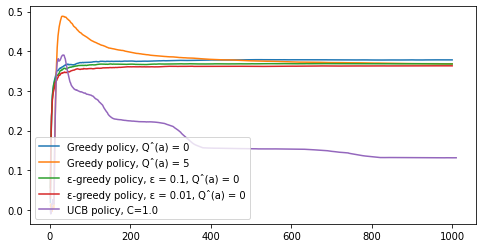

In [722]:
# 1 - Get the means of steps across the runs of a policy
# 2 - Plot each timestep across the policies

fig = plt.figure(figsize=(8, 4))

# Greedy with Q^(a) = 0
plt.plot(greedy_bandit_q0.results.index.values, greedy_bandit_q0.results.mean(axis=1))

# Greedy with Q^(a) = 5
plt.plot(greedy_bandit_q5.results.index.values, greedy_bandit_q5.results.mean(axis=1))

# Epsilon at 0.1
plt.plot(egreedy_bandit_e01.results.index.values, egreedy_bandit_e01.results.mean(axis=1))

# Epsilon at 0.01
plt.plot(egreedy_bandit_e001.results.index.values, egreedy_bandit_e001.results.mean(axis=1))

# UCB at C=1
plt.plot(ucb_bandit_1.results.index.values, ucb_bandit_1.results.mean(axis=1))

plt.legend(['Greedy policy, Qˆ(a) = 0', 
            'Greedy policy, Qˆ(a) = 5',
            'ε-greedy policy, ε = 0.1, Qˆ(a) = 0',
            'ε-greedy policy, ε = 0.01, Qˆ(a) = 0',
            'UCB policy, C=1.0'
            ])

plt.show()

## Plot the rewards received

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

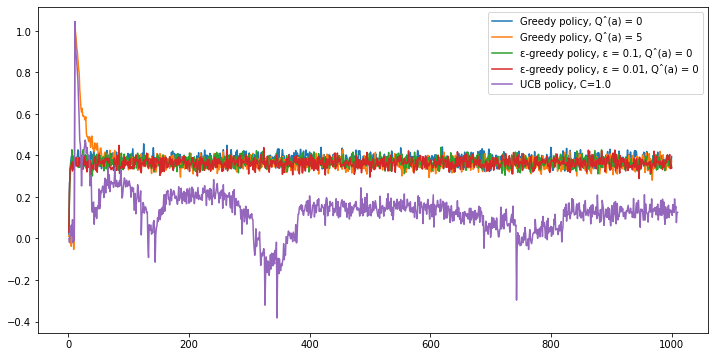

In [726]:
# 1 - Get the means of steps across the runs of a policy
# 2 - Plot each timestep across the policies

fig = plt.figure(figsize=(12, 6))

# Greedy with Q(a) = 0
#greedy_bandit_q0.__average_results__(greedy_bandit_q0.bandit_records, 'Reward Received')
plt.plot(greedy_bandit_q0.results.index.values, 
         greedy_bandit_q0.__average_results__(greedy_bandit_q0.bandit_records, 'Reward Received').mean(axis=1))

# Greedy with Q(a) = 5
#greedy_bandit_q5.__average_results__(greedy_bandit_q5.bandit_records, 'Reward Received')
plt.plot(greedy_bandit_q5.results.index.values, 
         greedy_bandit_q5.__average_results__(greedy_bandit_q5.bandit_records, 'Reward Received').mean(axis=1))

# Epsilon at 0.1
plt.plot(egreedy_bandit_e01.results.index.values, 
         egreedy_bandit_e01.__average_results__(egreedy_bandit_e01.bandit_records, 'Reward Received').mean(axis=1))

# Epsilon at 0.01
plt.plot(egreedy_bandit_e001.results.index.values, 
         egreedy_bandit_e001.__average_results__(egreedy_bandit_e001.bandit_records, 'Reward Received').mean(axis=1))

# UCB at C=0.5
plt.plot(ucb_bandit_1.results.index.values, 
         ucb_bandit_1.__average_results__(ucb_bandit_1.bandit_records, 'Reward Received').mean(axis=1))

plt.legend(['Greedy policy, Qˆ(a) = 0', 
            'Greedy policy, Qˆ(a) = 5',
            'ε-greedy policy, ε = 0.1, Qˆ(a) = 0',
            'ε-greedy policy, ε = 0.01, Qˆ(a) = 0',
            'UCB policy, C=1.0'
            ])

plt.show()